**Data Source**
1. Digital Elevation is created using Shuttle Radar Topography Mission (SRTM) from https://search.earthdata.nasa.gov/search?q=SRTM&gdf=GeoTIFF&lat=46.99259988883141&long=-124.5849609375&zoom=7

2. Stations points are from snotel_wa_4000ft.geojson file

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import rasterio
import numpy as np
import netCDF4 as nc
import requests, zipfile, os , io

In [2]:
fname = 'srtm_12_03'

In [3]:
# os.mkdir("./finalprojectdata")
# os.replace(fname+".tif", './finalprojectdata/'+fname+".tif") 

In [4]:
file_path = 'data/'+fname+".tif"
dem_data = rasterio.open(file_path)

In [5]:
elevation = dem_data.read()

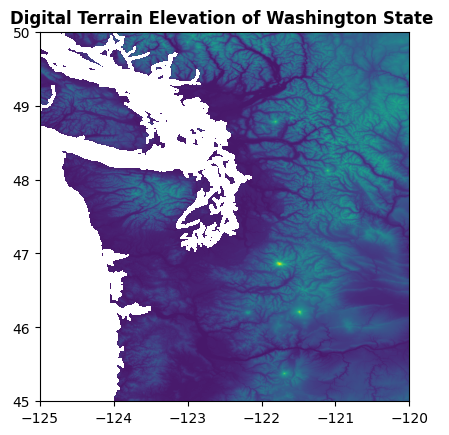

<Axes: title={'center': 'Digital Terrain Elevation of Washington State '}>

In [6]:
#2D Map
from rasterio.plot import show

show(dem_data, cmap = "viridis", title="Digital Terrain Elevation of Washington State ")

In [7]:
#Set elevation less than 1200 m to 0

mask_elevation = (elevation > 1200) * elevation

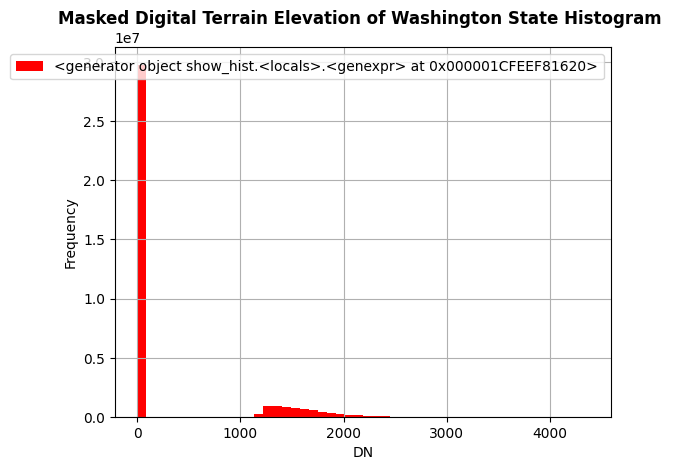

In [8]:
#Check whether raster calculation done correctly
from rasterio.plot import show_hist

show_hist(mask_elevation, bins=50, title="Masked Digital Terrain Elevation of Washington State Histogram ")

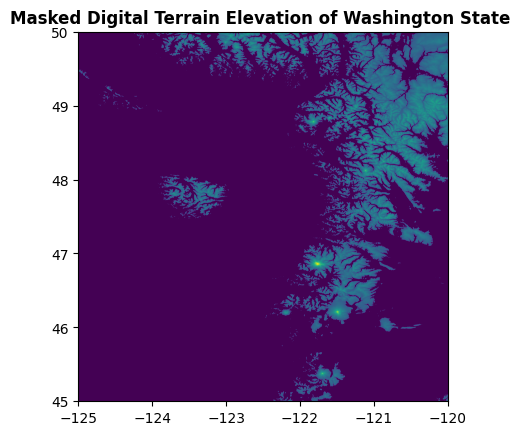

<Axes: title={'center': 'Masked Digital Terrain Elevation of Washington State '}>

In [9]:
transform = dem_data.transform
show(mask_elevation, cmap = "viridis", title="Masked Digital Terrain Elevation of Washington State ", transform=transform)

In [10]:
#Add stations and shoreline on the raster map 

# os.replace(fname_1+".geojson", './finalprojectdata/'+fname_1+".geojson") 
fname_1 = "snotel_wa_4000ft"
file_path_1 = 'data/'+fname_1+".geojson"
stations = gpd.read_file(file_path_1)

In [11]:
stations

,name,id,datasource,geometry
0,Stevens Pass,791:WA:SNTL,NRCS,POINT Z (-121.09288 47.74607 3950.00000)
1,Satus Pass,1231:WA:SNTL,NRCS,POINT Z (-120.67734 45.98797 3960.00000)
2,Rex River,911:WA:SNTL,NRCS,POINT Z (-121.60475 47.30218 3810.00000)
3,Sheep Canyon,748:WA:SNTL,NRCS,POINT Z (-122.25393 46.19325 3990.00000)
4,Stampede Pass,788:WA:SNTL,NRCS,POINT Z (-121.34162 47.27427 3850.00000)
5,Wells Creek,909:WA:SNTL,NRCS,POINT Z (-121.78976 48.86610 4030.00000)
6,Swamp Creek,975:WA:SNTL,NRCS,POINT Z (-120.78267 48.57142 3930.00000)
7,Lynn Lake,1069:WA:SNTL,NRCS,POINT Z (-121.77972 47.20172 3900.00000)
8,Lone Pine,591:WA:SNTL,NRCS,POINT Z (-121.96288 46.27143 3930.00000)
9,Olallie Meadows,672:WA:SNTL,NRCS,POINT Z (-121.44213 47.37406 4030.00000)


In [12]:
#shoreline

fname_2 = "ne_10m_ocean"
file_path_2 = 'data/ne_10m_ocean/'+fname_2+".shp"
shoreline = gpd.read_file(file_path_2)

<Axes: title={'center': 'Digital Terrain Elevation of Washington State'}, xlabel='Longitude', ylabel='Latitude'>

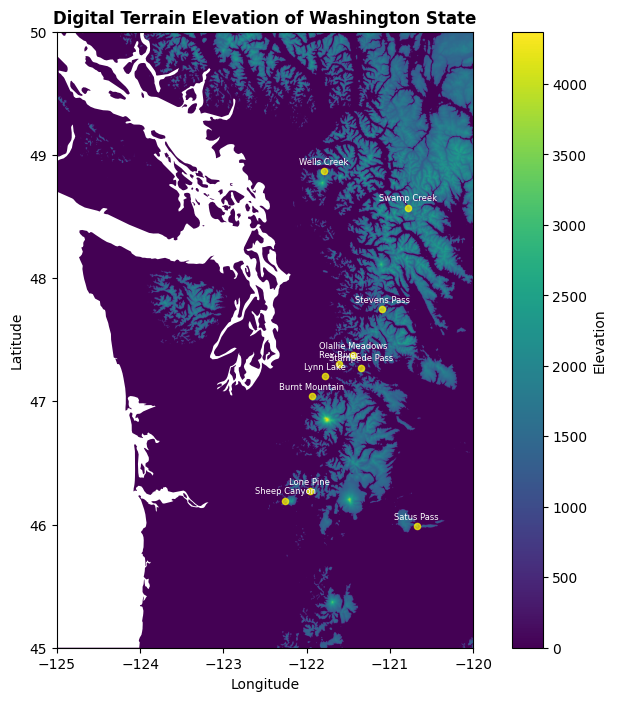

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
show(mask_elevation, cmap = "viridis", title="Digital Terrain Elevation of Washington State", ax=ax, transform=transform)
stations.plot(ax=plt.gca(), marker='o', color='yellow', markersize=20, alpha=0.7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#create colorbar using ScalarMappable from matplotlib
from matplotlib.cm import ScalarMappable

sm = ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=elevation.max()))
sm.set_array([]) #empty array 
cbar = plt.colorbar(sm, ax=ax, label='Elevation')
sm.set_array(elevation.flatten())

#label stations name
for idx, row in stations.iterrows():
    ax.annotate(row['name'], (row.geometry.x, row.geometry.y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6, color='white')

#add shoreline
from shapely.geometry import box
bbox = box(-125, 45, -120, 50)
clipped_shoreline = gpd.clip(shoreline, bbox)
clipped_shoreline.plot(ax=ax, color="white")

# #save file as a png format image
# plt.savefig('final_plot.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

In [ ]:
#Export Data
mask_elevation = mask_elevation.squeeze()

with rasterio.open("masked elevation","w",
    driver='GTiff',
    height=mask_elevation.shape[0],
    width=mask_elevation.shape[1],
    count=1,
    dtype=mask_elevation.dtype,
    crs=dem_data.crs,
    transform=dem_data.transform,
) as dst:
    dst.write(mask_elevation, 1)
    
#use the created file to do 3d visualization using any preferred software (e.g. qgis, cloud compare, arcgis)